# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split
import pNormSoftmax

# Evaluate logits

In [5]:
AUROC_min = lambda x,y: 1-metrics.AUROC(x,y)
SAC = 0.95
SAC_min = lambda x,y: torch.as_tensor(1-metrics.SAC(x,y,SAC))
d_aurc = {}
d_auroc = {}
d_baseline_aurc = {}
d_baseline_auroc = {}
d_baseline_sac = {}
d_sac = {}
acc = {}
norm_l2 = {}
norm_l4 = {}
logits_mean = {}

In [6]:
DATASET = 'Cifar100'
VAL_SIZE = 0.1 #5000
for MODEL_ARC in models.list_models('cifar100'):
    print(MODEL_ARC)
    #if MODEL_ARC in df['model'].values:
    #    print('ja foi')
    #    continue
    if 'quantized' in MODEL_ARC:
        print('quantized - skip')
        continue
    with torch.no_grad():
        try: logits,labels = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'test', device = dev, data_dir = DATA_PATH)
        except: print('not found'); continue

    logits_val,labels_val,logits_test,labels_test = split.split_logits(logits,labels,VAL_SIZE)
    risk_val = measures.wrong_class(logits_val,labels_val).float()
    risk_test = measures.wrong_class(logits_test,labels_test).float()
    acc[MODEL_ARC] = (1-risk_test.mean().item())
    p,beta = pNormSoftmax.optimize.p_and_beta(logits_val,risk_val,metrics.AURC)
    #T_nll = pNormSoftmax.optimize.T_fromloss(logits_val,labels_val,torch.nn.CrossEntropyLoss())
    d_baseline_aurc[MODEL_ARC] = metrics.AURC(risk_test,measures.MSP(logits_test))
    d_aurc[MODEL_ARC] = metrics.AURC(risk_test,pNormSoftmax.pNormSoftmax(logits_test,p,beta))
    #d_aurc[MODEL_ARC] = metrics.AURC(risk_test,measures.MSP(logits_test.div(T_nll)))

    p,beta = pNormSoftmax.optimize.p_and_beta(logits_val,risk_val,AUROC_min)

    d_auroc[MODEL_ARC] = metrics.AUROC(risk_test,pNormSoftmax.pNormSoftmax(logits_test,p,beta))
    d_baseline_auroc[MODEL_ARC] = metrics.AUROC(risk_test,measures.MSP(logits_test))
    #d_auroc[MODEL_ARC] = metrics.AUROC(risk_test,measures.MSP(logits_test.div(T_nll)))
    p,beta = pNormSoftmax.optimize.p_and_beta(logits_val,risk_val,AUROC_min)

    d_sac[MODEL_ARC] = metrics.SAC(risk_test,pNormSoftmax.pNormSoftmax(logits_test,p,beta),SAC)
    d_baseline_sac[MODEL_ARC] = metrics.SAC(risk_test,measures.MSP(logits_test),SAC)
    norm_l2[MODEL_ARC] = pNormSoftmax.centralize(logits_test).norm(2,dim=-1).mean().item()
    norm_l4[MODEL_ARC] = pNormSoftmax.centralize(logits_test).norm(4,dim=-1).mean().item()
    logits_mean[MODEL_ARC] = logits_test.mean().item()
    
    

DenseNet121
DenseNet169
DenseNet201
DenseNet161
SimpleDLA
not found
DLA
DPN26
DPN92
EfficientNetB0
GoogLeNet
LeNet
MobileNet
not found
MobileNetV2
PNASNetA
PNASNetB
PreActResNet18
not found
PreActResNet34
not found
PreActResNet50
PreActResNet101
PreActResNet152
RegNetX_200MF
RegNetX_400MF
RegNetY_400MF
ResNet18
ResNet34
ResNet50
ResNet101
ResNet152
ResNeXt29_2x64d
ResNeXt29_4x64d
ResNeXt29_8x64d
ResNeXt29_32x4d
SENet18
ShuffleNetG2
not found
ShuffleNetG3
not found
ShuffleNetV2
not found
VGG_11
VGG_13
VGG_16
VGG_19
WideResNet28_10


In [7]:
baseline_aurc = np.array(list(d_baseline_aurc.values()))
baseline_auroc = np.array(list(d_baseline_auroc.values()))
baseline_sac = np.array(list(d_baseline_sac.values()))
sac = np.array(list(d_sac.values()))
aurc = np.array(list(d_aurc.values()))
auroc = np.array(list(d_auroc.values()))
acc = np.array(list(acc.values()))

norm_l2 = np.array(list(norm_l2.values()))
norm_l4 = np.array(list(norm_l4.values()))
logits_mean = np.array(list(logits_mean.values()))

In [8]:
((auroc-baseline_auroc)).min()*100

-0.5388720885464271

In [17]:
gain_aurc = ((baseline_aurc-aurc)/baseline_aurc)
gain_auroc = -(baseline_auroc-auroc)

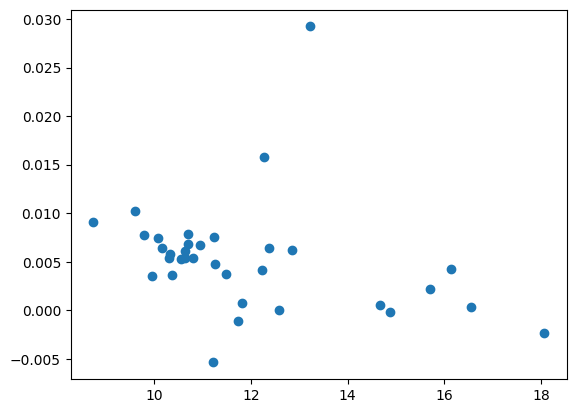

In [18]:
plt.scatter(norm_l4,gain_auroc)

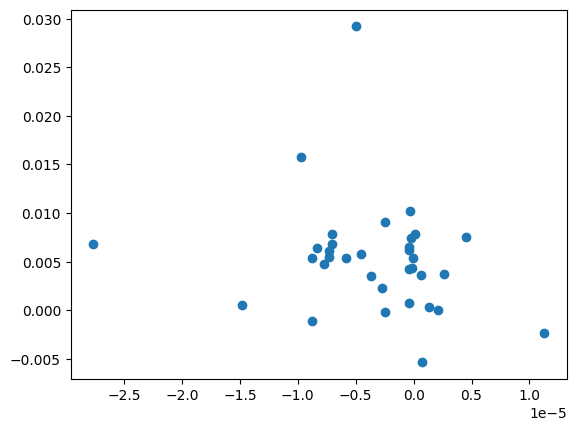

In [19]:
plt.scatter(logits_mean,gain_auroc)